In [151]:
import time

import numpy
import matplotlib.pyplot as plt
import numpy as np
import scipy.special as sp_spec
import scipy.stats as sp_stats

## Assignment 2A. Problem 2.2.8 SVI.

### Generate data
The cell below generates data for the LDA model. Note, for simplicity, we are using N_d = N for all d.

In [152]:
import torch
import torch.distributions as t_dist

def generate_data(D, N, K, W, eta, alpha):
    """
    Torch implementation for generating data using the LDA model. Faster for larger datasets.
    D = number of documents
    N = number of words in each document
    K = number of topics
    W = number of words in vocabulary
    """
    # sample K topics
    beta_dist = t_dist.Dirichlet(torch.from_numpy(eta))
    beta = beta_dist.sample([K])  # size K x W

    # sample document topic distribution
    theta_dist = t_dist.Dirichlet(torch.from_numpy(alpha))
    theta = theta_dist.sample([D]) # size D x K

    # sample word to topic assignment
    z_dist = t_dist.OneHotCategorical(probs=theta)
    z = z_dist.sample([N])
    z = torch.einsum("ndk->dnk", z)

    # sample word from selected topics
    beta_select = torch.einsum("kw, dnk -> dnw", beta, z)
    w_dist = t_dist.OneHotCategorical(probs=beta_select)
    w = w_dist.sample([1])

    w = w.reshape(D, N, W)

    return w.numpy(), z.numpy(), theta.numpy(), beta.numpy()

torch.manual_seed(1)

D_sim = 500
N_sim = 500 #5000
K_sim = 2
W_sim = 10

eta_sim = np.ones(W_sim)
eta_sim[3] = 0.0001     # Expect word 3 to not appear in data
eta_sim[1] = 3.         # Expect word 1 to be most common in data
alpha_sim = np.ones(K_sim) * 1.0
w0, z0, theta0, beta0 = generate_data(D_sim, N_sim, K_sim, W_sim, eta_sim, alpha_sim)
w_cat = w0.argmax(axis=-1)  # remove one hot encoding
unique_z, counts_z = numpy.unique(z0[0, :], return_counts=True)
unique_w, counts_w = numpy.unique(w_cat[0, :], return_counts=True)

# Sanity checks for data generation
print(f"Average z of each document should be close to theta of document. \n Theta of doc 0: {theta0[0]}"
      f" \n Mean z of doc 0: {z0[0].mean(axis=0)}")
print(f"Beta of topic 0: {beta0[0]}")
print(f"Beta of topic 1: {beta0[1]}")
print(f"Word to topic assignment, z, of document 0: {z0[0, 0:10]}")
print(f"Observed words, w, of document 0: {w_cat[0, 0:10]}")
print(f"Unique words and count of document 0: {[f'{u}: {c}' for u, c in zip(unique_w, counts_w)]}")

Average z of each document should be close to theta of document. 
 Theta of doc 0: [0.140 0.860] 
 Mean z of doc 0: [0.142 0.858]
Beta of topic 0: [0.135 0.309 0.036 0.000 0.009 0.068 0.043 0.092 0.103 0.206]
Beta of topic 1: [0.351 0.217 0.081 0.000 0.014 0.099 0.105 0.046 0.016 0.072]
Word to topic assignment, z, of document 0: [[1.000 0.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.000 1.000]
 [1.000 0.000]
 [0.000 1.000]
 [0.000 1.000]]
Observed words, w, of document 0: [9 1 0 5 6 0 0 5 6 1]
Unique words and count of document 0: ['0: 159', '1: 118', '2: 24', '4: 7', '5: 61', '6: 43', '7: 25', '8: 19', '9: 44']


### Helper functions

In [153]:
def log_multivariate_beta_function(a, axis=None):
    return np.sum(sp_spec.gammaln(a)) - sp_spec.gammaln(np.sum(a, axis=axis))

### CAVI Implementation, ELBO and initialization

In [154]:
def initialize_q(w, D, N, K, W):
    """
    Random initialization.
    """
    phi_init = np.random.random(size=(D, N, K))
    phi_init = phi_init / np.sum(phi_init, axis=-1, keepdims=True)
    gamma_init = np.random.randint(1, 10, size=(D, K))
    lmbda_init = np.random.randint(1, 10, size=(K, W))
    return phi_init, gamma_init, lmbda_init

def update_q_Z(w, gamma, lmbda):
    D, N, W = w.shape
    K, W = lmbda.shape
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))   # size K x W
    log_rho = np.zeros((D, N, K))
    w_label = w.argmax(axis=-1)
    for d in range(D):
        for n in range(N):
            E_log_beta_wdn = E_log_beta[:, int(w_label[d, n])]
            E_log_theta_d = E_log_theta[d]
            log_rho_n = E_log_theta_d + E_log_beta_wdn
            log_rho[d, n, :] = log_rho_n

    phi = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=-1, keepdims=True))
    return phi

def update_q_theta(phi, alpha):
    E_Z = phi
    D, N, K = phi.shape
    gamma = np.zeros((D, K))
    for d in range(D):
        E_Z_d = E_Z[d]
        gamma[d] = alpha + np.sum(E_Z_d, axis=0)  # sum over N
    return gamma

def update_q_beta(w, phi, eta):
    E_Z = phi
    D, N, W = w.shape
    K = phi.shape[-1]
    lmbda = np.zeros((K, W))
    for k in range(K):
        lmbda[k, :] = eta
        for d in range(D):
            for n in range(N):
                lmbda[k, :] += E_Z[d,n,k] * w[d,n]  # Sum over d and n
    return lmbda

def calculate_elbo(w, phi, gamma, lmbda, eta, alpha):
    D, N, K = phi.shape
    W = eta.shape[0]
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))  # size K x W
    E_Z = phi  # size D, N, K
    log_Beta_alpha = log_multivariate_beta_function(alpha)
    log_Beta_eta = log_multivariate_beta_function(eta)
    log_Beta_gamma = np.array([log_multivariate_beta_function(gamma[d, :]) for d in range(D)])
    dg_gamma = sp_spec.digamma(gamma)
    log_Beta_lmbda = np.array([log_multivariate_beta_function(lmbda[k, :]) for k in range(K)])
    dg_lmbda = sp_spec.digamma(lmbda)

    neg_CE_likelihood = np.einsum("dnk, kw, dnw", E_Z, E_log_beta, w)
    neg_CE_Z = np.einsum("dnk, dk -> ", E_Z, E_log_theta)
    neg_CE_theta = -D * log_Beta_alpha + np.einsum("k, dk ->", alpha - 1, E_log_theta)
    neg_CE_beta = -K * log_Beta_eta + np.einsum("w, kw ->", eta - 1, E_log_beta)
    H_Z = -np.einsum("dnk, dnk ->", E_Z, np.log(E_Z))
    gamma_0 = np.sum(gamma, axis=1)
    dg_gamma0 = sp_spec.digamma(gamma_0)
    H_theta = np.sum(log_Beta_gamma + (gamma_0 - K) * dg_gamma0 - np.einsum("dk, dk -> d", gamma - 1, dg_gamma))
    lmbda_0 = np.sum(lmbda, axis=1)
    dg_lmbda0 = sp_spec.digamma(lmbda_0)
    H_beta = np.sum(log_Beta_lmbda + (lmbda_0 - W) * dg_lmbda0 - np.einsum("kw, kw -> k", lmbda - 1, dg_lmbda))
    return neg_CE_likelihood + neg_CE_Z + neg_CE_theta + neg_CE_beta + H_Z + H_theta + H_beta

def CAVI_algorithm(w, K, n_iter, eta, alpha):
  D, N, W = w.shape
  phi, gamma, lmbda = initialize_q(w, D, N, K, W)

  # Store output per iteration
  elbo = np.zeros(n_iter)
  phi_out = np.zeros((n_iter, D, N, K))
  gamma_out = np.zeros((n_iter, D, K))
  lmbda_out = np.zeros((n_iter, K, W))

  for i in range(0, n_iter):

    ###### CAVI updates #######

    # q(Z) update
    phi = update_q_Z(w, gamma, lmbda)

    # q(theta) update
    gamma = update_q_theta(phi, alpha)

    # q(beta) update
    lmbda = update_q_beta(w, phi, eta)

    # ELBO
    elbo[i] = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)

    # outputs
    phi_out[i] = phi
    gamma_out[i] = gamma
    lmbda_out[i] = lmbda

  return phi_out, gamma_out, lmbda_out, elbo

n_iter0 = 100
K0 = K_sim
W0 = W_sim
eta_prior0 = np.ones(W0)
alpha_prior0 = np.ones(K0)
phi_out0, gamma_out0, lmbda_out0, elbo0 = CAVI_algorithm(w0, K0, n_iter0, eta_prior0, alpha_prior0)
final_phi0 = phi_out0[-1]
final_gamma0 = gamma_out0[-1]
final_lmbda0 = lmbda_out0[-1]

In [155]:
precision = 3
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"Final E[theta] of doc 0 CAVI:  {np.round(final_gamma0[0] / np.sum(final_gamma0[0], axis=0, keepdims=True), precision)}")
print(f"True theta of doc 0:          {np.round(theta0[0], precision)}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"Final E[beta] k=0: {np.round(final_lmbda0[0, :] / np.sum(final_lmbda0[0, :], axis=-1, keepdims=True), precision)}")
print(f"Final E[beta] k=1: {np.round(final_lmbda0[1, :] / np.sum(final_lmbda0[1, :], axis=-1, keepdims=True), precision)}")
print(f"True beta k=0: {np.round(beta0[0, :], precision)}")
print(f"True beta k=1: {np.round(beta0[1, :], precision)}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
Final E[theta] of doc 0 CAVI:  [0.271 0.729]
True theta of doc 0:          [0.140 0.860]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
Final E[beta] k=0: [0.079 0.337 0.023 0.000 0.009 0.061 0.030 0.102 0.122 0.237]
Final E[beta] k=1: [0.396 0.196 0.090 0.000 0.014 0.104 0.117 0.037 0.002 0.046]
True beta k=0: [0.135 0.309 0.036 0.000 0.009 0.068 0.043 0.092 0.103 0.206]
True beta k=1: [0.351 0.217 0.081 0.000 0.014 0.099 0.105 0.046 0.016 0.072]


### SVI Implementation

Using the CAVI updates as a template, finish the code below.

In [156]:
def update_q_Z_svi(d, w, phi, gamma, lmbda):
    """
    Done. Keeping the old phis.
    """
    D, N, W = w.shape
    K, W = lmbda.shape
    E_log_theta = sp_spec.digamma(gamma) - sp_spec.digamma(np.sum(gamma, axis=1, keepdims=True))  # size D x K
    E_log_beta = sp_spec.digamma(lmbda) - sp_spec.digamma(np.sum(lmbda, axis=1, keepdims=True))   # size K x W
    log_rho = np.zeros((N, K))
    w_label = w.argmax(axis=-1)
    for n in range(N):
        E_log_beta_wdn = E_log_beta[:, int(w_label[d, n])] # K
        E_log_theta_d = E_log_theta[d] # K
        log_rho_n = E_log_theta_d + E_log_beta_wdn
        log_rho[n, :] = log_rho_n # N x K

    phi[d] = np.exp(log_rho - sp_spec.logsumexp(log_rho, axis=-1, keepdims=True)) # N x K
    return phi # D x N x K

def update_q_theta_svi(d, phi, gamma, alpha):
    """
    Done. Keeping the old gammas.
    """
    E_Z = phi
    D, N, K = phi.shape
    E_Z_d = E_Z[d]
    gamma[d] = alpha + np.sum(E_Z_d, axis=0)  # sum over N
    return gamma

def update_q_beta_svi(batch, w, phi, eta):
    """
    Done
    """
    E_Z = phi
    D, N, W = w.shape
    K = phi.shape[-1]
    S = batch.size
    lmbda_hat_s = np.zeros((S, K, W)) # S x K x W
    for s in range(S):
        for k in range(K):
            lmbda_hat_s[s, k, :] = eta
            sum_prod = 0.0
            for n in range(N):
                sum_prod += E_Z[batch[s],n,k] * w[batch[s],n]  # Sum over n given d = batch[s]
            lmbda_hat_s[s, k, :] += D * sum_prod
    return np.sum(lmbda_hat_s, axis=0)

def SVI_is_converging(phi_old, phi_new, gamma_old, gamma_new, tol=1e-3): # N x K, K
    """
    Check for convergence by norm of the 2D array phi and the 1D array gamma.
    """
    phi_diff = np.linalg.norm(phi_new - phi_old)
    gamma_diff = np.linalg.norm(gamma_new - gamma_old)
    """
    Check for convergence by maximum change of the 2D array phi and the 1D array gamma.
    """
    # phi_diff = np.max(np.abs(phi_new - phi_old))
    # gamma_diff = np.max(np.abs(gamma_new - gamma_old))
    
    return phi_diff < tol and gamma_diff < tol

def SVI_algorithm(w, K, S, n_iter, eta, alpha, tao=5, kappa=0.9, tol=1e-3):
  """
  Add SVI Specific code here.
  """
  D, N, W = w.shape
  phi, gamma, lmbda = initialize_q(w, D, N, K, W)

  # Store output per iteration
  elbo = np.zeros(n_iter)
  phi_out = np.zeros((n_iter, D, N, K))
  gamma_out = np.zeros((n_iter, D, K))
  lmbda_out = np.zeros((n_iter, K, W))
  
  # tao = 1 #delay
  # kappa = 0.7 #forgetting rate (0.5, 1]

  for i in range(0, n_iter):
    # Sample batch and set step size, rho.
    # Set rho
    rho = (i + tao) ** (-kappa)
    # Sample a minibatch of documents
    batch = np.random.choice(D, S, replace=False) # S
    
    ###### SVI updates #######
    # Doing it by document to find convergence
    for d in batch:
        # Set gamma_dk for all k to 1; is this necessary?
        gamma[d] = np.ones(K)
        # Check for convergence
        while True:
            phi_old = phi[d]
            gamma_old = gamma[d]
            phi = update_q_Z_svi(d, w, phi, gamma, lmbda) # D x N x K
            gamma = update_q_theta_svi(d, phi, gamma, alpha) # D x K
            if SVI_is_converging(phi_old, phi[d], gamma_old, gamma[d], tol): break
    
    #DONE
    sum_lmbda_hat_s = update_q_beta_svi(batch, w, phi, eta) # K x W
    lmbda = (1 - rho) * lmbda + rho / S * sum_lmbda_hat_s
    
    # ELBO
    elbo[i] = calculate_elbo(w, phi, gamma, lmbda, eta, alpha)

    # outputs
    phi_out[i] = phi
    gamma_out[i] = gamma
    lmbda_out[i] = lmbda

  return phi_out, gamma_out, lmbda_out, elbo

### CASE 1
Tiny dataset

In [157]:
np.random.seed(0)

# Data simulation parameters
D1 = 50
N1 = 50
K1 = 2
W1 = 5
eta_sim1 = np.ones(W1)
alpha_sim1 = np.ones(K1)

w1, z1, theta1, beta1 = generate_data(D1, N1, K1, W1, eta_sim1, alpha_sim1)

# Inference parameters
n_iter_cavi1 = 100
n_iter_svi1 = 100
eta_prior1 = np.ones(W1) * 1.
alpha_prior1 = np.ones(K1) * 1.
S1 = 5 # batch size

start_cavi1 = time.time()
phi_out1_cavi, gamma_out1_cavi, lmbda_out1_cavi, elbo1_cavi = CAVI_algorithm(w1, K1, n_iter_cavi1, eta_prior1, alpha_prior1)
end_cavi1 = time.time()

start_svi1 = time.time()
phi_out1_svi, gamma_out1_svi, lmbda_out1_svi, elbo1_svi = SVI_algorithm(w1, K1, S1, n_iter_svi1, eta_prior1, alpha_prior1)
end_svi1 = time.time()

final_phi1_cavi = phi_out1_cavi[-1]
final_gamma1_cavi = gamma_out1_cavi[-1]
final_lmbda1_cavi = lmbda_out1_cavi[-1]
final_phi1_svi = phi_out1_svi[-1]
final_gamma1_svi = gamma_out1_svi[-1]
final_lmbda1_svi = lmbda_out1_svi[-1]

#### Evaluation
Do not expect perfect results in terms expectations being identical to the "true" theta and beta.
Do not expect the ELBO plot of your SVI alg to be the same as the CAVI alg. However, it should increase and be in the same ball park as that of the CAVI alg.

In [171]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"E[theta] of doc 0 SVI:  {final_gamma1_svi[0] / np.sum(final_gamma1_svi[0], axis=0, keepdims=True)}")
print(f"E[theta] of doc 0 CAVI: {final_gamma1_cavi[0] / np.sum(final_gamma1_cavi[0], axis=0, keepdims=True)}")
print(f"True theta of doc 0:    {theta1[0]}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"E[beta] SVI k=0:    {final_lmbda1_svi[0, :] / np.sum(final_lmbda1_svi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] SVI k=1:    {final_lmbda1_svi[1, :] / np.sum(final_lmbda1_svi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] CAVI k=0:   {final_lmbda1_cavi[0, :] / np.sum(final_lmbda1_cavi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] CAVI k=1:   {final_lmbda1_cavi[1, :] / np.sum(final_lmbda1_cavi[1, :], axis=-1, keepdims=True)}")
print(f"True beta k=0:      {beta1[0, :]}")
print(f"True beta k=1:      {beta1[1, :]}")

print(f"Time SVI: {end_svi1 - start_svi1}")
print(f"Time CAVI: {end_cavi1 - start_cavi1}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
E[theta] of doc 0 SVI:  [0.667 0.333]
E[theta] of doc 0 CAVI: [0.738 0.262]
True theta of doc 0:    [0.787 0.213]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
E[beta] SVI k=0:    [0.680 0.018 0.052 0.130 0.120]
E[beta] SVI k=1:    [0.067 0.019 0.347 0.385 0.182]
E[beta] CAVI k=0:   [0.663 0.037 0.029 0.006 0.266]
E[beta] CAVI k=1:   [0.093 0.002 0.360 0.500 0.045]
True beta k=0:      [0.636 0.039 0.055 0.019 0.250]
True beta k=1:      [0.176 0.008 0.329 0.429 0.058]
Time SVI: 0.24774599075317383
Time CAVI: 1.5961582660675049


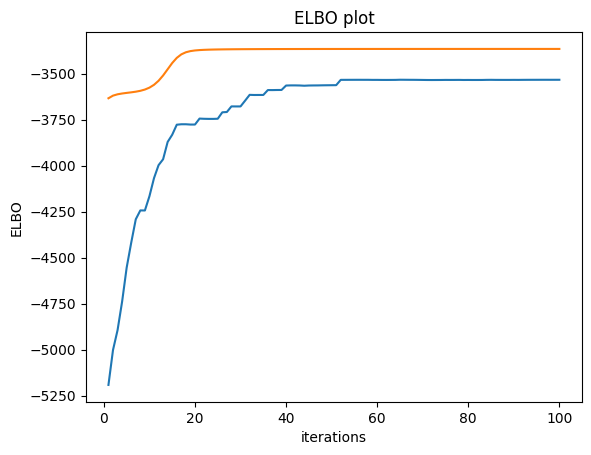

In [159]:
plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo1_svi[np.arange(0, n_iter_svi1, int(n_iter_svi1 / n_iter_cavi1))])
plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo1_cavi)
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")
plt.show()

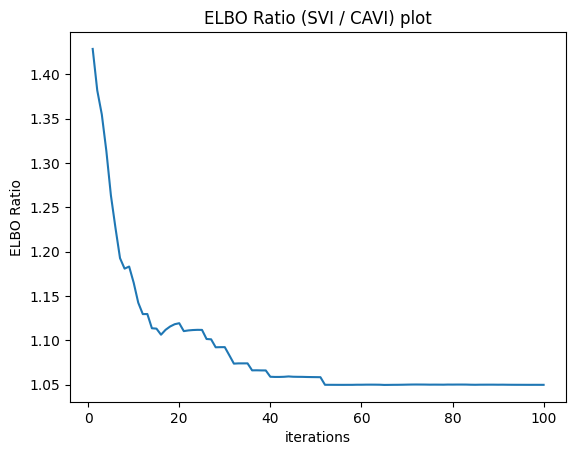

Average of the last 11 ELBO Ratios (SVI / CAVI): 1.049893390165306


In [172]:
def plot_elbo_ratio(elbo1_svi, elbo1_cavi, n_iter_svi1, n_iter_cavi1):
    # Divide the CAVI and SVI ELBO and plot the results
    elbo_ratio = elbo1_svi[np.arange(0, n_iter_svi1, int(n_iter_svi1 / n_iter_cavi1))] / elbo1_cavi
    plt.plot(list(range(1, n_iter_cavi1 + 1)), elbo_ratio)
    plt.title("ELBO Ratio (SVI / CAVI) plot")
    plt.xlabel("iterations")
    plt.ylabel("ELBO Ratio")
    plt.show()
    
    print(f"Average of the last 11 ELBO Ratios (SVI / CAVI): {np.mean(elbo_ratio[-11:])}")

plot_elbo_ratio(elbo1_svi, elbo1_cavi, n_iter_svi1, n_iter_cavi1)


The SVI is 6x faster than the CAVI. The ELBO is in the range of ~5%.
Batch size is smaller, that's why the SVI looks a bit all over the place.

### CASE 2
Small dataset

In [161]:
np.random.seed(0)

# Data simulation parameters
D2 = 1000
N2 = 50
K2 = 3
W2 = 10
eta_sim2 = np.ones(W2)
alpha_sim2 = np.ones(K2)

w2, z2, theta2, beta2 = generate_data(D2, N2, K2, W2, eta_sim2, alpha_sim2)

# Inference parameters
n_iter_cavi2 = 100
n_iter_svi2 = 100
eta_prior2 = np.ones(W2) * 1.
alpha_prior2 = np.ones(K2) * 1.
S2 = 100 # batch size

start_cavi2 = time.time()
phi_out2_cavi, gamma_out2_cavi, lmbda_out2_cavi, elbo2_cavi = CAVI_algorithm(w2, K2, n_iter_cavi2, eta_prior2, alpha_prior2)
end_cavi2 = time.time()

start_svi2 = time.time()
phi_out2_svi, gamma_out2_svi, lmbda_out2_svi, elbo2_svi = SVI_algorithm(w2, K2, S2, n_iter_svi2, eta_prior2, alpha_prior2)
end_svi2 = time.time()

final_phi2_cavi = phi_out2_cavi[-1]
final_gamma2_cavi = gamma_out2_cavi[-1]
final_lmbda2_cavi = lmbda_out2_cavi[-1]
final_phi2_svi = phi_out2_svi[-1]
final_gamma2_svi = gamma_out2_svi[-1]
final_lmbda2_svi = lmbda_out2_svi[-1]

#### Evaluation
Do not expect perfect results in terms expectations being identical to the "true" theta and beta.
Do not expect the ELBO plot of your SVI alg to be the same as the CAVI alg. However, it should increase and be in the same ball park as that of the CAVI alg.

In [162]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f"----- Recall label switching - compare E[theta] and true theta and check for label switching -----")
print(f"E[theta] of doc 0 SVI:      {final_gamma2_svi[0] / np.sum(final_gamma2_svi[0], axis=0, keepdims=True)}")
print(f"E[theta] of doc 0 CAVI:     {final_gamma2_cavi[0] / np.sum(final_gamma2_cavi[0], axis=0, keepdims=True)}")
print(f"True theta of doc 0:        {theta2[0]}")

print(f"----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----")
print(f"E[beta] k=0:    {final_lmbda2_svi[0, :] / np.sum(final_lmbda2_svi[0, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=1:    {final_lmbda2_svi[1, :] / np.sum(final_lmbda2_svi[1, :], axis=-1, keepdims=True)}")
print(f"E[beta] k=2:    {final_lmbda2_svi[2, :] / np.sum(final_lmbda2_svi[2, :], axis=-1, keepdims=True)}")
print(f"True beta k=0:  {beta2[0, :]}")
print(f"True beta k=1:  {beta2[1, :]}")
print(f"True beta k=2:  {beta2[2, :]}")

print(f"Time SVI: {end_svi2 - start_svi2}")
print(f"Time CAVI: {end_cavi2 - start_cavi2}")

----- Recall label switching - compare E[theta] and true theta and check for label switching -----
E[theta] of doc 0 SVI:      [0.327 0.346 0.327]
E[theta] of doc 0 CAVI:     [0.148 0.139 0.713]
True theta of doc 0:        [0.037 0.111 0.853]
----- Recall label switching - e.g. E[beta_0] could be fit to true theta_1. -----
E[beta] k=0:    [0.014 0.085 0.051 0.066 0.349 0.025 0.186 0.080 0.015 0.130]
E[beta] k=1:    [0.054 0.191 0.115 0.016 0.054 0.086 0.176 0.098 0.006 0.205]
E[beta] k=2:    [0.081 0.286 0.028 0.157 0.057 0.016 0.080 0.102 0.074 0.119]
True beta k=0:  [0.061 0.237 0.024 0.087 0.021 0.008 0.323 0.104 0.009 0.127]
True beta k=1:  [0.015 0.128 0.046 0.140 0.223 0.069 0.118 0.094 0.074 0.092]
True beta k=2:  [0.075 0.192 0.129 0.012 0.214 0.049 0.001 0.079 0.009 0.239]
Time SVI: 17.890661478042603
Time CAVI: 36.119837284088135


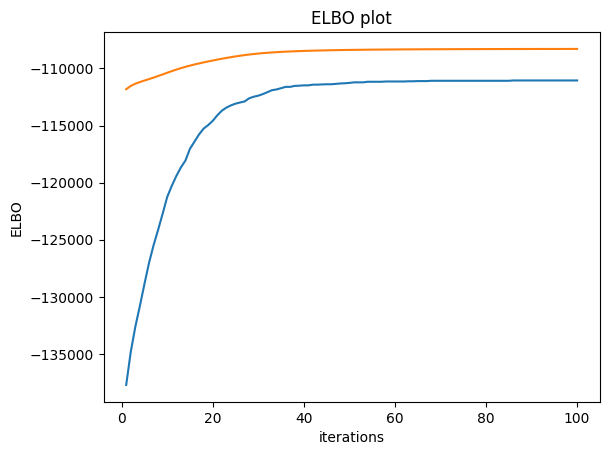

In [163]:
plt.plot(list(range(1, n_iter_cavi2 + 1)), elbo2_svi[np.arange(0, n_iter_svi2, int(n_iter_svi2 / n_iter_cavi2))])
plt.plot(list(range(1, n_iter_cavi2 + 1)), elbo2_cavi)
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")
plt.show()

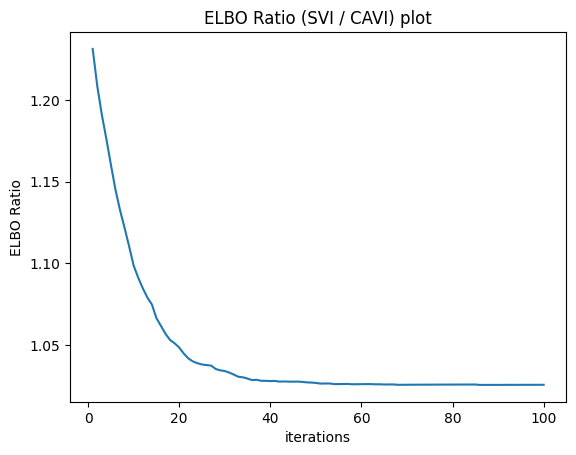

Average of the last 11 ELBO Ratios (SVI / CAVI): 1.0254647795253622


In [173]:
# Add your own code for evaluation here (will not be graded)
plot_elbo_ratio(elbo2_svi, elbo2_cavi, n_iter_svi2, n_iter_cavi2)

The SVI is 2x faster than the CAVI. The ELBO is in the range of ~2.5%.

### CASE 3
Medium small dataset, one iteration for time analysis.

In [165]:
np.random.seed(0)

# Data simulation parameters
D3 = 10**4
N3 = 500
K3 = 5
W3 = 10
eta_sim3 = np.ones(W3)
alpha_sim3 = np.ones(K3)

w3, z3, theta3, beta3 = generate_data(D3, N3, K3, W3, eta_sim3, alpha_sim3)

# Inference parameters
n_iter3 = 1
eta_prior3 = np.ones(W3) * 1.
alpha_prior3 = np.ones(K3) * 1.
S3 = 100 # batch size

start_cavi3 = time.time()
phi_out3_cavi, gamma_out3_cavi, lmbda_out3_cavi, elbo3_cavi = CAVI_algorithm(w3, K3, n_iter3, eta_prior3, alpha_prior3)
end_cavi3 = time.time()

start_svi3 = time.time()
phi_out3_svi, gamma_out3_svi, lmbda_out3_svi, elbo3_svi = SVI_algorithm(w3, K3, S3, n_iter3, eta_prior3, alpha_prior3)
end_svi3 = time.time()

final_phi3_cavi = phi_out3_cavi[-1]
final_gamma3_cavi = gamma_out3_cavi[-1]
final_lmbda3_cavi = lmbda_out3_cavi[-1]
final_phi3_svi = phi_out3_svi[-1]
final_gamma3_svi = gamma_out3_svi[-1]
final_lmbda3_svi = lmbda_out3_svi[-1]

In [166]:
print(f"Examine per iteration run time.")
print(f"Time SVI: {end_svi3 - start_svi3}")
print(f"Time CAVI: {end_cavi3 - start_cavi3}")

Examine per iteration run time.
Time SVI: 16.330700397491455
Time CAVI: 55.64692306518555


We can see that the first iteration is almost 4x faster.

In [167]:
# Add your own code for evaluation here (will not be graded)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def test_svi_with_parameters(w, K, S, n_iter, eta, alpha, tao_values, kappa_values, tol_values, n_runs):
    """
    Test the SVI algorithm with different tao, kappa, and tolerance values.
    
    Parameters:
    - w: word data
    - K: number of topics
    - S: batch size
    - n_iter: number of iterations
    - eta: prior for beta
    - alpha: prior for theta
    - tao_values: list of tao values to test
    - kappa_values: list of kappa values to test
    - tol_values: list of tolerance values to test
    - n_runs: number of runs to average over
    
    Returns:
    - Averages of the last SVI/CAVI ELBO ratios for each parameter combination
    """
    D, N, W = w.shape
    results = []
    
    phi_out_cavi, gamma_out_cavi, lmbda_out_cavi, elbo_cavi = CAVI_algorithm(w, K, n_iter, eta, alpha)

    for tao in tqdm(tao_values):
        for kappa in kappa_values:
            for tol in tol_values:
                elbo_ratios = []
                for _ in range(n_runs):
                    phi_out_svi, gamma_out_svi, lmbda_out_svi, elbo_svi = SVI_algorithm(w, K, S, n_iter, eta, alpha, tao, kappa, tol)
                    elbo_ratio = elbo_svi[-1] / elbo_cavi[-1]
                    elbo_ratios.append(elbo_ratio)
                
                avg_elbo_ratio = np.mean(elbo_ratios)
                results.append((tao, kappa, tol, avg_elbo_ratio))
                print(f"tao: {tao}, kappa: {kappa}, tol: {tol}, Avg ELBO Ratio: {avg_elbo_ratio}")

    return results

In [168]:
tao_values = np.array([1.0, 5.0, 10.0, 15.0, 20.0])
kappa_values = np.array([0.5, 0.6, 0.7, 0.8, 0.9])
tol_values = np.array([1e-3, 1e-4, 1e-5, 1e-6])
n_runs = 5
expected_time = (end_svi2 - start_svi2) * n_runs * tol_values.size * kappa_values.size * tao_values.size
print(f"Expected runtime: {expected_time / 60}")

Expected runtime: 149.088845650355


In [170]:
#results = test_svi_with_parameters(w2, K2, S2, n_iter_svi2, eta_prior2, alpha_prior2, tao_values, kappa_values, tol_values, n_runs)